Total Null Columns (should be zero for all):
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
city             0
zip              0
dtype: int64
      bedrooms  bathrooms  floors  waterfront  view  condition  sqft_above  \
471        4.0       4.50     1.0           0     0          3        3890   
2518       2.0       1.00     1.0           0     0          4        1090   
23         4.0       2.50     2.0           0     0          3        2730   
3922       3.0       1.00     1.0           0     0          5        1020   
135        4.0       1.75     1.0           0     0          4        1960   
...        ...        ...     ...         ...   ...        ...         ...   
3002       4.0       3.50     2.0           0     0          3        4410   
2307       5.0       2.50     2.0

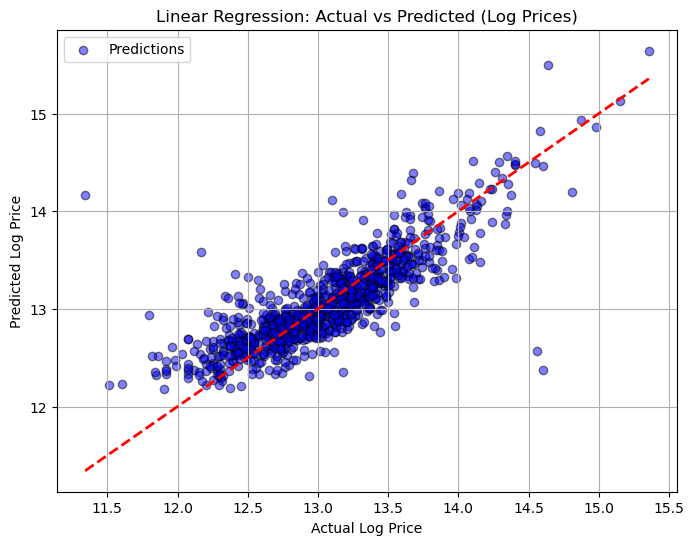

In [51]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Load dataset
housing_data = pd.read_csv('washington_state_housing_data.csv')

# Check for missing values
print('Total Null Columns (should be zero for all):')
print(housing_data.isnull().sum())

# Drop rows where price is 0
housing_data = housing_data[housing_data['price'] != 0]

# Create age-based features
current_year = datetime.datetime.now().year
housing_data['house_age'] = current_year - housing_data['yr_built']

# Renovation age (fallback to house_age if never renovated)
housing_data['renovation_age'] = housing_data.apply(
    lambda row: current_year - row['yr_renovated'] if row['yr_renovated'] > 0 else row['house_age'],
    axis=1
)

# Drop year columns (we replaced them)
housing_data.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)

# Drop city column (not needed, using zip)
housing_data.drop(['city'], axis=1, inplace=True)

# Target encode zip with average prices for each zip-code
zip_avg_prices = housing_data.groupby('zip')['price'].mean()

housing_data['zip_encoded'] = housing_data['zip'].map(zip_avg_prices)

# Drop the original zip column
housing_data.drop('zip', axis=1, inplace=True)

# Log-transform skewed features
housing_data['log_price'] = np.log(housing_data['price'])
housing_data['log_sqft_living'] = np.log(housing_data['sqft_living'] + 1)
housing_data['log_sqft_lot'] = np.log(housing_data['sqft_lot'] + 1)

# Drop raw versions
housing_data.drop(['price', 'sqft_living', 'sqft_lot'], axis=1, inplace=True)

# Final split: Features (X) and target (y)
X = housing_data.drop('log_price', axis=1)
y = housing_data['log_price']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"{X_test}")

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Plot Predicted vs Actual (log prices)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', edgecolors='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title("Linear Regression: Actual vs Predicted (Log Prices)")
plt.legend()
plt.grid(True)
plt.show()
